In [1]:
import os
import sys
import torch
import random
import dataloader
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, Dataset

In [2]:
class DATAset(Dataset):
    def __init__(self, data):
        self.train_data, self.train_label, *_ = data
      
    def __len__(self):
        return len(self.train_data)
      
    def __getitem__(self, idx):
        return self.train_data[idx], self.train_label[idx]

In [3]:
class EEGNet(nn.Module):
    def __init__(self, act_func):
        super(EEGNet, self).__init__()
        self.firstconv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False),
            nn.BatchNorm2d(num_features=16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )

        layers1 = [
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False),
            nn.BatchNorm2d(num_features=32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        ]
        if act_func == 'elu': layers1.append(nn.ELU(alpha=1.0))
        elif act_func == 'leaky_relu': layers1.append(nn.LeakyReLU())
        elif act_func == 'relu': layers1.append(nn.ReLU())
        else: raise ValueError('activation function error!')
        layers1.append(nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0))
        layers1.append(nn.Dropout(p=0.25))
        self.depthwiseConv = nn.Sequential(*layers1)

        layers2 = [
          nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False),
          nn.BatchNorm2d(num_features=32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        ]
        if act_func == 'elu': layers2.append(nn.ELU(alpha=1.0))
        elif act_func == 'leaky_relu': layers2.append(nn.LeakyReLU())
        elif act_func == 'relu': layers2.append(nn.ReLU())
        else: raise ValueError('activation function error!')
        layers2.append(nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0))
        layers2.append(nn.Dropout(p=0.25))
        self.separableConv = nn.Sequential(*layers2)

        self.classify = nn.Sequential(
            nn.Linear(in_features=736, out_features=2, bias=True)
        )

    def forward(self, x):
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(x.shape[0], -1)
        x = self.classify(x)
        return x
    
print(EEGNet('elu'))

EEGNet(
  (firstconv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (depthwiseConv): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (separableConv): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (classify): Sequential(
    (0): Linear(in_features=736, out_features=2, bias=True)
  )
)


In [4]:
class DeepConvNet(nn.Module):
    def __init__(self, act_func):
        super(DeepConvNet, self).__init__()
        
        if act_func != 'leaky_relu' and act_func != 'elu' and act_func != 'relu':
            raise ValueError('activation function error!')
            
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=25, kernel_size=(1, 5))
        self.conv2 = nn.Conv2d(in_channels=25, out_channels=25, kernel_size=(2, 1))
        self.BN1 = nn.BatchNorm2d(num_features=25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.activation1 = nn.ELU(alpha=1.0)
        if act_func == 'leaky_relu':
            self.activation1 = nn.LeakyReLU()
        elif act_func == 'relu':
            self.activation1 = nn.ReLU()
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=(1, 2))
        self.drop1 = nn.Dropout(p=0.5) 
        
        self.conv3 = nn.Conv2d(in_channels=25, out_channels=50, kernel_size=(1, 5))
        self.BN2 = nn.BatchNorm2d(num_features=50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.activation2 = nn.ELU(alpha=1.0)
        if act_func == 'leaky_relu':
            self.activation2 = nn.LeakyReLU()
        elif act_func == 'relu':
            self.activation2 = nn.ReLU()
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=(1, 2))
        self.drop2 = nn.Dropout(p=0.5)
        
        self.conv4 = nn.Conv2d(in_channels=50, out_channels=100, kernel_size=(1, 5))
        self.BN3 = nn.BatchNorm2d(num_features=100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.activation3 = nn.ELU(alpha=1.0)
        if act_func == 'leaky_relu':
            self.activation3 = nn.LeakyReLU()
        elif act_func == 'relu':
            self.activation3 = nn.ReLU()
        self.maxpool3 = torch.nn.MaxPool2d(kernel_size=(1, 2))
        self.drop3 = nn.Dropout(p=0.5)
        
        self.conv5 = nn.Conv2d(in_channels=100, out_channels=200, kernel_size=(1, 5))
        self.BN4 = nn.BatchNorm2d(num_features=200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.activation4 = nn.ELU(alpha=1.0)
        if act_func == 'leaky_relu':
            self.activation4 = nn.LeakyReLU()
        elif act_func == 'relu':
            self.activation4 = nn.ReLU()
        self.maxpool4 = torch.nn.MaxPool2d(kernel_size=(1, 2))
        self.drop4 = nn.Dropout(p=0.5)
        
        self.dense = nn.Linear(in_features=8600, out_features=2, bias=True)
    
    def forward(self, x):
        x = self.drop1(self.maxpool1(self.activation1(self.BN1(self.conv2(self.conv1(x))))))
        x = self.drop2(self.maxpool2(self.activation2(self.BN2(self.conv3(x)))))
        x = self.drop3(self.maxpool3(self.activation3(self.BN3(self.conv4(x)))))
        x = self.drop4(self.maxpool4(self.activation4(self.BN4(self.conv5(x)))))
        x = x.view(x.shape[0], -1)
        x = self.dense(x)
        return x
    
print(DeepConvNet('elu'))

DeepConvNet(
  (conv1): Conv2d(1, 25, kernel_size=(1, 5), stride=(1, 1))
  (conv2): Conv2d(25, 25, kernel_size=(2, 1), stride=(1, 1))
  (BN1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation1): ELU(alpha=1.0)
  (maxpool1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(25, 50, kernel_size=(1, 5), stride=(1, 1))
  (BN2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation2): ELU(alpha=1.0)
  (maxpool2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.5, inplace=False)
  (conv4): Conv2d(50, 100, kernel_size=(1, 5), stride=(1, 1))
  (BN3): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation3): ELU(alpha=1.0)
  (maxpool3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)


In [5]:
def Train(name, network, Epoch, LR, b_size):
    batch_size = b_size
    lr = LR
    EPOCH = Epoch
    optimizer = optim.SGD(network.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    train_loader = DataLoader(DATAset(dataloader.read_bci_data()), batch_size=batch_size, shuffle=True, num_workers=0)
    isGPU = torch.cuda.is_available()

    if isGPU:
        network = network.cuda()
        print('========== ' + str(name) + ' (Train on GPU)' + ' ==========')
    else:
        print('========== ' + str(name) + ' (Train on CPU)' + ' ==========')

    train_accuracy, test_accuracy = [], []
    *_, test_data, test_label = dataloader.read_bci_data()
    test_data, test_label = torch.from_numpy(test_data), torch.from_numpy(test_label)
    if isGPU:
        test_data, test_label = test_data.cuda(), test_label.cuda()

    for epoch in range(1, EPOCH+1):
        accuracy_sum = 0
        for data, label in train_loader:
            if isGPU:
                data, label = data.cuda(), label.cuda()
            output = network(data)
            loss = criterion(output.float(), label.long())
            accuracy_sum += float((torch.argmax(output, dim=1) == label).sum())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
          
        with torch.no_grad():
            accuracy_sum /= 1080
            train_accuracy.append([epoch, accuracy_sum])
            test_output = torch.argmax(network(test_data), dim=1)
            accuracy = float((test_output == test_label).sum()) / float(len(test_data))
            test_accuracy.append([epoch, accuracy])
#             sys.stdout.write('\rtraining: %.1f %%' % float(epoch*100 / EPOCH))
        
        print(
            'Epoch:', epoch,
            '| train accuracy: %.4f' % accuracy_sum,
            '| test accuracy: %.2f' % accuracy
        )
            
    return train_accuracy, test_accuracy

In [6]:
def setup_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
epoch = 300
lr = 0.006
batch_size = 64

setup_seed(65)
eegnet_elu_train_acc, eegnet_elu_test_acc = Train('EEGNet_elu',
                                                  EEGNet('elu').double(),
                                                  epoch,
                                                  lr,
                                                  batch_size)
setup_seed(65)
eegnet_relu_train_acc, eegnet_relu_test_acc = Train('EEGNet_relu',
                                                    EEGNet('relu').double(),
                                                    epoch,
                                                    lr,
                                                    batch_size)
setup_seed(65)
eegnet_leaky_relu_train_acc, eegnet_leaky_relu_test_acc = Train('EEGNet_leaky_relu',
                                                                EEGNet('leaky_relu').double(),
                                                                epoch,
                                                                lr,
                                                                batch_size)
setup_seed(65)
deepconvnet_elu_train_acc, deepconvnet_elu_test_acc = Train('DeepConvNet_elu',
                                                            DeepConvNet('elu').double(),
                                                            epoch,
                                                            lr,
                                                            batch_size)
setup_seed(65)
deepconvnet_relu_train_acc, deepconvnet_relu_test_acc = Train('DeepConvNet_relu',
                                                              DeepConvNet('relu').double(),
                                                              epoch,
                                                              lr,
                                                              batch_size)
setup_seed(65)
deepconvnet_leaky_relu_train_acc, deepconvnet_leaky_relu_test_acc = Train('DeepConvNet_leaky_relu',
                                                                          DeepConvNet('leaky_relu').double(),
                                                                          epoch,
                                                                          lr,
                                                                          batch_size)

========== EEGNet_elu (Train on GPU) ==========
Epoch: 1 | train accuracy: 0.6306 | test accuracy: 0.69
Epoch: 2 | train accuracy: 0.7204 | test accuracy: 0.69
Epoch: 3 | train accuracy: 0.7306 | test accuracy: 0.70
Epoch: 4 | train accuracy: 0.7472 | test accuracy: 0.71
Epoch: 5 | train accuracy: 0.7639 | test accuracy: 0.72
Epoch: 6 | train accuracy: 0.7676 | test accuracy: 0.72
Epoch: 7 | train accuracy: 0.7537 | test accuracy: 0.71
Epoch: 8 | train accuracy: 0.7667 | test accuracy: 0.72
Epoch: 9 | train accuracy: 0.7741 | test accuracy: 0.71
Epoch: 10 | train accuracy: 0.7639 | test accuracy: 0.73
Epoch: 11 | train accuracy: 0.7787 | test accuracy: 0.73
Epoch: 12 | train accuracy: 0.7796 | test accuracy: 0.73
Epoch: 13 | train accuracy: 0.7907 | test accuracy: 0.72
Epoch: 14 | train accuracy: 0.7778 | test accuracy: 0.73
Epoch: 15 | train accuracy: 0.7796 | test accuracy: 0.73
Epoch: 16 | train accuracy: 0.8028 | test accuracy: 0.73
Epoch: 17 | train accuracy: 0.8019 | test accurac

Epoch: 144 | train accuracy: 0.9639 | test accuracy: 0.81
Epoch: 145 | train accuracy: 0.9704 | test accuracy: 0.81
Epoch: 146 | train accuracy: 0.9657 | test accuracy: 0.80
Epoch: 147 | train accuracy: 0.9676 | test accuracy: 0.80
Epoch: 148 | train accuracy: 0.9583 | test accuracy: 0.79
Epoch: 149 | train accuracy: 0.9667 | test accuracy: 0.80
Epoch: 150 | train accuracy: 0.9722 | test accuracy: 0.81
Epoch: 151 | train accuracy: 0.9694 | test accuracy: 0.81
Epoch: 152 | train accuracy: 0.9685 | test accuracy: 0.82
Epoch: 153 | train accuracy: 0.9648 | test accuracy: 0.82
Epoch: 154 | train accuracy: 0.9639 | test accuracy: 0.80
Epoch: 155 | train accuracy: 0.9667 | test accuracy: 0.81
Epoch: 156 | train accuracy: 0.9648 | test accuracy: 0.80
Epoch: 157 | train accuracy: 0.9713 | test accuracy: 0.80
Epoch: 158 | train accuracy: 0.9741 | test accuracy: 0.82
Epoch: 159 | train accuracy: 0.9778 | test accuracy: 0.81
Epoch: 160 | train accuracy: 0.9685 | test accuracy: 0.82
Epoch: 161 | t

Epoch: 286 | train accuracy: 0.9852 | test accuracy: 0.81
Epoch: 287 | train accuracy: 0.9833 | test accuracy: 0.82
Epoch: 288 | train accuracy: 0.9870 | test accuracy: 0.83
Epoch: 289 | train accuracy: 0.9852 | test accuracy: 0.81
Epoch: 290 | train accuracy: 0.9870 | test accuracy: 0.80
Epoch: 291 | train accuracy: 0.9861 | test accuracy: 0.81
Epoch: 292 | train accuracy: 0.9898 | test accuracy: 0.81
Epoch: 293 | train accuracy: 0.9898 | test accuracy: 0.82
Epoch: 294 | train accuracy: 0.9898 | test accuracy: 0.82
Epoch: 295 | train accuracy: 0.9843 | test accuracy: 0.81
Epoch: 296 | train accuracy: 0.9889 | test accuracy: 0.81
Epoch: 297 | train accuracy: 0.9861 | test accuracy: 0.82
Epoch: 298 | train accuracy: 0.9769 | test accuracy: 0.82
Epoch: 299 | train accuracy: 0.9796 | test accuracy: 0.82
Epoch: 300 | train accuracy: 0.9787 | test accuracy: 0.81
========== EEGNet_relu (Train on GPU) ==========
Epoch: 1 | train accuracy: 0.5574 | test accuracy: 0.67
Epoch: 2 | train accuracy

Epoch: 129 | train accuracy: 0.9852 | test accuracy: 0.86
Epoch: 130 | train accuracy: 0.9778 | test accuracy: 0.83
Epoch: 131 | train accuracy: 0.9648 | test accuracy: 0.85
Epoch: 132 | train accuracy: 0.9750 | test accuracy: 0.84
Epoch: 133 | train accuracy: 0.9685 | test accuracy: 0.84
Epoch: 134 | train accuracy: 0.9787 | test accuracy: 0.84
Epoch: 135 | train accuracy: 0.9713 | test accuracy: 0.84
Epoch: 136 | train accuracy: 0.9630 | test accuracy: 0.84
Epoch: 137 | train accuracy: 0.9667 | test accuracy: 0.85
Epoch: 138 | train accuracy: 0.9741 | test accuracy: 0.84
Epoch: 139 | train accuracy: 0.9796 | test accuracy: 0.84
Epoch: 140 | train accuracy: 0.9741 | test accuracy: 0.84
Epoch: 141 | train accuracy: 0.9759 | test accuracy: 0.85
Epoch: 142 | train accuracy: 0.9704 | test accuracy: 0.85
Epoch: 143 | train accuracy: 0.9731 | test accuracy: 0.84
Epoch: 144 | train accuracy: 0.9787 | test accuracy: 0.84
Epoch: 145 | train accuracy: 0.9824 | test accuracy: 0.83
Epoch: 146 | t

Epoch: 271 | train accuracy: 0.9852 | test accuracy: 0.85
Epoch: 272 | train accuracy: 0.9898 | test accuracy: 0.85
Epoch: 273 | train accuracy: 0.9843 | test accuracy: 0.86
Epoch: 274 | train accuracy: 0.9852 | test accuracy: 0.84
Epoch: 275 | train accuracy: 0.9880 | test accuracy: 0.85
Epoch: 276 | train accuracy: 0.9935 | test accuracy: 0.85
Epoch: 277 | train accuracy: 0.9843 | test accuracy: 0.85
Epoch: 278 | train accuracy: 0.9898 | test accuracy: 0.85
Epoch: 279 | train accuracy: 0.9852 | test accuracy: 0.84
Epoch: 280 | train accuracy: 0.9861 | test accuracy: 0.83
Epoch: 281 | train accuracy: 0.9889 | test accuracy: 0.86
Epoch: 282 | train accuracy: 0.9852 | test accuracy: 0.84
Epoch: 283 | train accuracy: 0.9880 | test accuracy: 0.86
Epoch: 284 | train accuracy: 0.9889 | test accuracy: 0.84
Epoch: 285 | train accuracy: 0.9880 | test accuracy: 0.86
Epoch: 286 | train accuracy: 0.9880 | test accuracy: 0.84
Epoch: 287 | train accuracy: 0.9815 | test accuracy: 0.84
Epoch: 288 | t

Epoch: 114 | train accuracy: 0.9750 | test accuracy: 0.84
Epoch: 115 | train accuracy: 0.9676 | test accuracy: 0.84
Epoch: 116 | train accuracy: 0.9685 | test accuracy: 0.83
Epoch: 117 | train accuracy: 0.9713 | test accuracy: 0.85
Epoch: 118 | train accuracy: 0.9583 | test accuracy: 0.83
Epoch: 119 | train accuracy: 0.9685 | test accuracy: 0.84
Epoch: 120 | train accuracy: 0.9731 | test accuracy: 0.84
Epoch: 121 | train accuracy: 0.9704 | test accuracy: 0.84
Epoch: 122 | train accuracy: 0.9657 | test accuracy: 0.86
Epoch: 123 | train accuracy: 0.9704 | test accuracy: 0.80
Epoch: 124 | train accuracy: 0.9620 | test accuracy: 0.83
Epoch: 125 | train accuracy: 0.9731 | test accuracy: 0.84
Epoch: 126 | train accuracy: 0.9685 | test accuracy: 0.83
Epoch: 127 | train accuracy: 0.9713 | test accuracy: 0.85
Epoch: 128 | train accuracy: 0.9824 | test accuracy: 0.84
Epoch: 129 | train accuracy: 0.9843 | test accuracy: 0.86
Epoch: 130 | train accuracy: 0.9815 | test accuracy: 0.83
Epoch: 131 | t

Epoch: 256 | train accuracy: 0.9898 | test accuracy: 0.84
Epoch: 257 | train accuracy: 0.9852 | test accuracy: 0.84
Epoch: 258 | train accuracy: 0.9880 | test accuracy: 0.83
Epoch: 259 | train accuracy: 0.9917 | test accuracy: 0.86
Epoch: 260 | train accuracy: 0.9861 | test accuracy: 0.84
Epoch: 261 | train accuracy: 0.9898 | test accuracy: 0.85
Epoch: 262 | train accuracy: 0.9889 | test accuracy: 0.85
Epoch: 263 | train accuracy: 0.9907 | test accuracy: 0.85
Epoch: 264 | train accuracy: 0.9880 | test accuracy: 0.84
Epoch: 265 | train accuracy: 0.9843 | test accuracy: 0.85
Epoch: 266 | train accuracy: 0.9917 | test accuracy: 0.83
Epoch: 267 | train accuracy: 0.9926 | test accuracy: 0.85
Epoch: 268 | train accuracy: 0.9889 | test accuracy: 0.84
Epoch: 269 | train accuracy: 0.9898 | test accuracy: 0.85
Epoch: 270 | train accuracy: 0.9907 | test accuracy: 0.86
Epoch: 271 | train accuracy: 0.9815 | test accuracy: 0.84
Epoch: 272 | train accuracy: 0.9880 | test accuracy: 0.85
Epoch: 273 | t

Epoch: 99 | train accuracy: 0.8389 | test accuracy: 0.74
Epoch: 100 | train accuracy: 0.8380 | test accuracy: 0.75
Epoch: 101 | train accuracy: 0.8491 | test accuracy: 0.74
Epoch: 102 | train accuracy: 0.8611 | test accuracy: 0.76
Epoch: 103 | train accuracy: 0.8472 | test accuracy: 0.72
Epoch: 104 | train accuracy: 0.8435 | test accuracy: 0.73
Epoch: 105 | train accuracy: 0.8315 | test accuracy: 0.73
Epoch: 106 | train accuracy: 0.8519 | test accuracy: 0.72
Epoch: 107 | train accuracy: 0.8463 | test accuracy: 0.72
Epoch: 108 | train accuracy: 0.8741 | test accuracy: 0.74
Epoch: 109 | train accuracy: 0.8472 | test accuracy: 0.72
Epoch: 110 | train accuracy: 0.8491 | test accuracy: 0.72
Epoch: 111 | train accuracy: 0.8648 | test accuracy: 0.74
Epoch: 112 | train accuracy: 0.8667 | test accuracy: 0.74
Epoch: 113 | train accuracy: 0.8611 | test accuracy: 0.74
Epoch: 114 | train accuracy: 0.8704 | test accuracy: 0.74
Epoch: 115 | train accuracy: 0.8704 | test accuracy: 0.74
Epoch: 116 | tr

Epoch: 241 | train accuracy: 0.9352 | test accuracy: 0.75
Epoch: 242 | train accuracy: 0.9250 | test accuracy: 0.75
Epoch: 243 | train accuracy: 0.9370 | test accuracy: 0.74
Epoch: 244 | train accuracy: 0.9380 | test accuracy: 0.72
Epoch: 245 | train accuracy: 0.9194 | test accuracy: 0.74
Epoch: 246 | train accuracy: 0.9417 | test accuracy: 0.74
Epoch: 247 | train accuracy: 0.9269 | test accuracy: 0.74
Epoch: 248 | train accuracy: 0.9370 | test accuracy: 0.75
Epoch: 249 | train accuracy: 0.9491 | test accuracy: 0.73
Epoch: 250 | train accuracy: 0.9407 | test accuracy: 0.72
Epoch: 251 | train accuracy: 0.9343 | test accuracy: 0.73
Epoch: 252 | train accuracy: 0.9454 | test accuracy: 0.73
Epoch: 253 | train accuracy: 0.9491 | test accuracy: 0.75
Epoch: 254 | train accuracy: 0.9333 | test accuracy: 0.73
Epoch: 255 | train accuracy: 0.9444 | test accuracy: 0.75
Epoch: 256 | train accuracy: 0.9426 | test accuracy: 0.74
Epoch: 257 | train accuracy: 0.9370 | test accuracy: 0.73
Epoch: 258 | t

Epoch: 83 | train accuracy: 0.8361 | test accuracy: 0.75
Epoch: 84 | train accuracy: 0.8333 | test accuracy: 0.74
Epoch: 85 | train accuracy: 0.8269 | test accuracy: 0.75
Epoch: 86 | train accuracy: 0.8296 | test accuracy: 0.75
Epoch: 87 | train accuracy: 0.8417 | test accuracy: 0.73
Epoch: 88 | train accuracy: 0.8491 | test accuracy: 0.73
Epoch: 89 | train accuracy: 0.8435 | test accuracy: 0.75
Epoch: 90 | train accuracy: 0.8306 | test accuracy: 0.75
Epoch: 91 | train accuracy: 0.8241 | test accuracy: 0.73
Epoch: 92 | train accuracy: 0.8343 | test accuracy: 0.74
Epoch: 93 | train accuracy: 0.8231 | test accuracy: 0.74
Epoch: 94 | train accuracy: 0.8519 | test accuracy: 0.76
Epoch: 95 | train accuracy: 0.8398 | test accuracy: 0.75
Epoch: 96 | train accuracy: 0.8519 | test accuracy: 0.75
Epoch: 97 | train accuracy: 0.8454 | test accuracy: 0.75
Epoch: 98 | train accuracy: 0.8296 | test accuracy: 0.76
Epoch: 99 | train accuracy: 0.8472 | test accuracy: 0.73
Epoch: 100 | train accuracy: 0.

Epoch: 225 | train accuracy: 0.8972 | test accuracy: 0.76
Epoch: 226 | train accuracy: 0.9028 | test accuracy: 0.75
Epoch: 227 | train accuracy: 0.9065 | test accuracy: 0.75
Epoch: 228 | train accuracy: 0.9056 | test accuracy: 0.75
Epoch: 229 | train accuracy: 0.8843 | test accuracy: 0.76
Epoch: 230 | train accuracy: 0.9102 | test accuracy: 0.75
Epoch: 231 | train accuracy: 0.9074 | test accuracy: 0.76
Epoch: 232 | train accuracy: 0.9028 | test accuracy: 0.76
Epoch: 233 | train accuracy: 0.9083 | test accuracy: 0.76
Epoch: 234 | train accuracy: 0.9130 | test accuracy: 0.75
Epoch: 235 | train accuracy: 0.9093 | test accuracy: 0.76
Epoch: 236 | train accuracy: 0.9000 | test accuracy: 0.75
Epoch: 237 | train accuracy: 0.9056 | test accuracy: 0.76
Epoch: 238 | train accuracy: 0.9037 | test accuracy: 0.72
Epoch: 239 | train accuracy: 0.9046 | test accuracy: 0.74
Epoch: 240 | train accuracy: 0.9037 | test accuracy: 0.74
Epoch: 241 | train accuracy: 0.9074 | test accuracy: 0.76
Epoch: 242 | t

Epoch: 67 | train accuracy: 0.8287 | test accuracy: 0.75
Epoch: 68 | train accuracy: 0.8287 | test accuracy: 0.74
Epoch: 69 | train accuracy: 0.8194 | test accuracy: 0.76
Epoch: 70 | train accuracy: 0.8194 | test accuracy: 0.74
Epoch: 71 | train accuracy: 0.8259 | test accuracy: 0.75
Epoch: 72 | train accuracy: 0.8259 | test accuracy: 0.73
Epoch: 73 | train accuracy: 0.8370 | test accuracy: 0.75
Epoch: 74 | train accuracy: 0.8296 | test accuracy: 0.75
Epoch: 75 | train accuracy: 0.8204 | test accuracy: 0.74
Epoch: 76 | train accuracy: 0.8417 | test accuracy: 0.74
Epoch: 77 | train accuracy: 0.8333 | test accuracy: 0.74
Epoch: 78 | train accuracy: 0.8287 | test accuracy: 0.74
Epoch: 79 | train accuracy: 0.8324 | test accuracy: 0.76
Epoch: 80 | train accuracy: 0.8185 | test accuracy: 0.76
Epoch: 81 | train accuracy: 0.8380 | test accuracy: 0.76
Epoch: 82 | train accuracy: 0.8287 | test accuracy: 0.74
Epoch: 83 | train accuracy: 0.8472 | test accuracy: 0.75
Epoch: 84 | train accuracy: 0.8

Epoch: 209 | train accuracy: 0.9000 | test accuracy: 0.77
Epoch: 210 | train accuracy: 0.8935 | test accuracy: 0.74
Epoch: 211 | train accuracy: 0.9000 | test accuracy: 0.76
Epoch: 212 | train accuracy: 0.9250 | test accuracy: 0.76
Epoch: 213 | train accuracy: 0.9176 | test accuracy: 0.76
Epoch: 214 | train accuracy: 0.9028 | test accuracy: 0.75
Epoch: 215 | train accuracy: 0.8870 | test accuracy: 0.76
Epoch: 216 | train accuracy: 0.8991 | test accuracy: 0.77
Epoch: 217 | train accuracy: 0.8991 | test accuracy: 0.76
Epoch: 218 | train accuracy: 0.9074 | test accuracy: 0.76
Epoch: 219 | train accuracy: 0.9102 | test accuracy: 0.76
Epoch: 220 | train accuracy: 0.9000 | test accuracy: 0.77
Epoch: 221 | train accuracy: 0.9046 | test accuracy: 0.78
Epoch: 222 | train accuracy: 0.9139 | test accuracy: 0.76
Epoch: 223 | train accuracy: 0.9037 | test accuracy: 0.74
Epoch: 224 | train accuracy: 0.9157 | test accuracy: 0.77
Epoch: 225 | train accuracy: 0.9065 | test accuracy: 0.77
Epoch: 226 | t

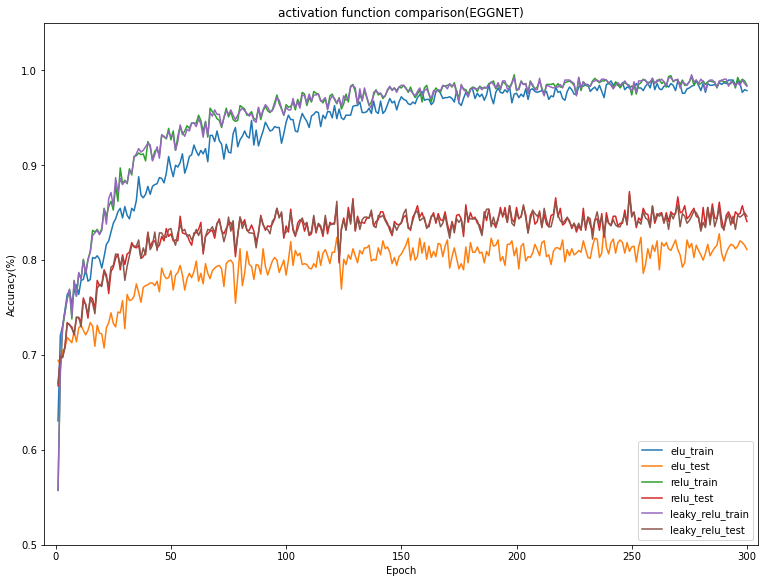

In [7]:
plt.figure(figsize=(12.8, 9.6)) 
plt.title("activation function comparison(EGGNET)")

plt.xlabel("Epoch")
plt.ylabel("Accuracy(%)")
plt.xlim(-5 , 305)
plt.ylim(0.5 , 1.05)

_eegnet_elu_train_acc = list(map(list, zip(*eegnet_elu_train_acc)))
_eegnet_elu_test_acc = list(map(list, zip(*eegnet_elu_test_acc)))
_eegnet_relu_train_acc = list(map(list, zip(*eegnet_relu_train_acc)))
_eegnet_relu_test_acc = list(map(list, zip(*eegnet_relu_test_acc)))
_eegnet_leaky_relu_train_acc = list(map(list, zip(*eegnet_leaky_relu_train_acc)))
_eegnet_leaky_relu_test_acc = list(map(list, zip(*eegnet_leaky_relu_test_acc)))

plt.plot(_eegnet_elu_train_acc[0][:], _eegnet_elu_train_acc[1][:], label = "elu_train")
plt.plot(_eegnet_elu_test_acc[0][:], _eegnet_elu_test_acc[1][:], label = "elu_test")
plt.plot(_eegnet_relu_train_acc[0][:], _eegnet_relu_train_acc[1][:], label = "relu_train")
plt.plot(_eegnet_relu_test_acc[0][:], _eegnet_relu_test_acc[1][:], label = "relu_test")
plt.plot(_eegnet_leaky_relu_train_acc[0][:], _eegnet_leaky_relu_train_acc[1][:], label = "leaky_relu_train")
plt.plot(_eegnet_leaky_relu_test_acc[0][:], _eegnet_leaky_relu_test_acc[1][:], label = "leaky_relu_test")
plt.legend(loc="lower right")
# plt.grid()
plt.show()

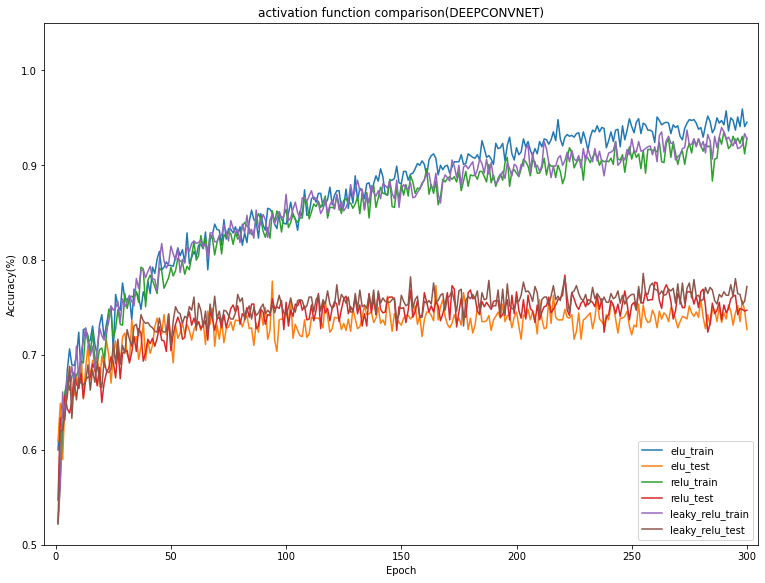

In [8]:
plt.figure(figsize=(12.8, 9.6)) 
plt.title("activation function comparison(DEEPCONVNET)")

plt.xlabel("Epoch")
plt.ylabel("Accuracy(%)")
plt.xlim(-5 , 305)
plt.ylim(0.5 , 1.05)

_deepconvnet_elu_train_acc = list(map(list, zip(*deepconvnet_elu_train_acc)))
_deepconvnet_elu_test_acc = list(map(list, zip(*deepconvnet_elu_test_acc)))
_deepconvnet_relu_train_acc = list(map(list, zip(*deepconvnet_relu_train_acc)))
_deepconvnet_relu_test_acc = list(map(list, zip(*deepconvnet_relu_test_acc)))
_deepconvnet_leaky_relu_train_acc = list(map(list, zip(*deepconvnet_leaky_relu_train_acc)))
_deepconvnet_leaky_relu_test_acc = list(map(list, zip(*deepconvnet_leaky_relu_test_acc)))

plt.plot(_deepconvnet_elu_train_acc[0][:], _deepconvnet_elu_train_acc[1][:], label = "elu_train")
plt.plot(_deepconvnet_elu_test_acc[0][:], _deepconvnet_elu_test_acc[1][:], label = "elu_test")
plt.plot(_deepconvnet_relu_train_acc[0][:], _deepconvnet_relu_train_acc[1][:], label = "relu_train")
plt.plot(_deepconvnet_relu_test_acc[0][:], _deepconvnet_relu_test_acc[1][:], label = "relu_test")
plt.plot(_deepconvnet_leaky_relu_train_acc[0][:], _deepconvnet_leaky_relu_train_acc[1][:], label = "leaky_relu_train")
plt.plot(_deepconvnet_leaky_relu_test_acc[0][:], _deepconvnet_leaky_relu_test_acc[1][:], label = "leaky_relu_test")
plt.legend(loc="lower right")
# plt.grid()
plt.show()